In [1]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.metrics import *
import seaborn as sns

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
df = pd.read_csv('data/full-data.csv')

In [4]:
df.shape

(1405, 3)

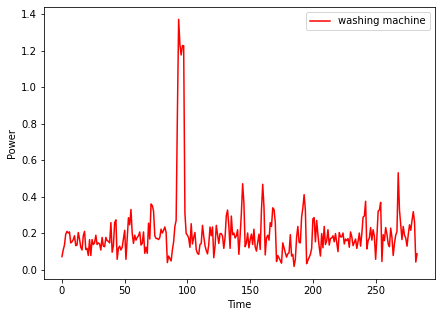

In [5]:
df_new = df.merge(df.groupby('Class')['Time'].min().reset_index(),on='Class',suffixes=(None,'_min'))
df_new['Time'] = df_new['Time'] - df_new['Time_min']
df_new = df_new[df_new['Class'] != 'None']
plt.figure(figsize=(7, 5))
sns.lineplot(x='Time',y='Power',data=df_new[df_new['Class'] == 'washing machine'],label='washing machine',color='red')

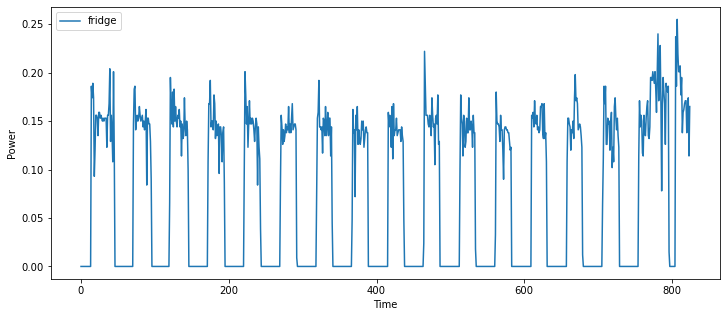

In [6]:
plt.figure(figsize=(12, 5))
sns.lineplot(x='Time',y='Power',data=df_new[df_new['Class'] == 'fridge'],label='fridge')

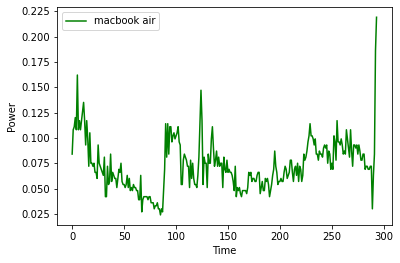

In [7]:
sns.lineplot(x='Time',y='Power',data=df_new[df_new['Class'] == 'macbook air'],label='macbook air',color='green')
plt.legend()

Spltting into overlapping sequences

In [5]:
n_steps = 5
samples = []
labels = []
i = 0

gap = 5
while i < len(df) - n_steps:
    # grab from i to i + 200
    if len(np.unique(df.iloc[i:i+n_steps,-1].values)) > 1:
        i = i + n_steps
        continue
    samples.append(df.iloc[i:i+n_steps,-2].values)
    #labels.append(df.iloc[i:i+n_steps,-1].values)
    labels.append(df.iloc[i,-1])
    i += gap
samples = np.concatenate(samples).reshape(-1,n_steps,1)
#labels = np.concatenate(labels).reshape(-1)
labels = np.array(labels).reshape(-1,1)

In [6]:
label_map = np.unique(labels.reshape(-1))
label_map = {label:i for i,label in enumerate(label_map)}

In [7]:
id2label = np.unique(labels.reshape(-1))

In [8]:
id2label = ['Fridge','Macbook Air','Washing machine']

In [9]:
label_map

{'fridge': 0, 'macbook air': 1, 'washing machine': 2}

one_hot_encoding function

In [10]:
def one_hot_encoding(labels,label_map):
    one_hot_labels = np.zeros((labels.shape[0],len(label_map)))
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            label = labels[i,j]
            one_hot = np.zeros(3)
            one_hot[label_map[label]] = 1
            one_hot_labels[i] = one_hot
    return one_hot_labels

In [11]:
def index_labelling(labels,label_map):
    index_labels = labels.copy()
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            label = labels[i,j]
            index_labels[i,j] = label_map[label]
    return index_labels

In [12]:
ohe_labels=one_hot_encoding(labels,label_map)
ohe_labels.shape

(273, 3)

In [13]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Saving data

In [14]:
# import pickle
# pickle.dump((x_train, x_test, y_train, y_test),open("data.pickle","wb"))

# Modelling

### 1) Deep Learning approach

In [14]:
import keras
from keras.layers import *
x_train, x_test, y_train, y_test = train_test_split(
    samples,ohe_labels, test_size=0.33, random_state=42)
x_train.shape, y_train.shape

Using TensorFlow backend.


((182, 5, 1), (182, 3))

### CNN 1D

In [15]:
n_features = 1 
# define model
model = keras.Sequential()
#model.add(BatchNormalization())
k = 3
model.add(Conv1D(filters=64, kernel_size=k, activation='relu', input_shape=(n_steps, n_features),name='conv'))
model.add(MaxPooling1D(pool_size=k))
model.add(Flatten(name='flatten'))
#model.add(BatchNormalization())
#model.add(Dense(24, activation='relu',name='dense'))
model.add(Dense(3,activation='softmax',name='classifier'))
model.compile(optimizer='adam', loss='mse',metrics=['acc'])

W0721 21:21:09.138770 19600 deprecation_wrapper.py:119] From E:\Anaconda\envs\sequence_classification\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [16]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(x_train, y_train, validation_split=0.1, epochs=500,batch_size=16, verbose=0,callbacks=[early_stopping])

W0721 21:21:18.005883 19600 deprecation_wrapper.py:119] From E:\Anaconda\envs\sequence_classification\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



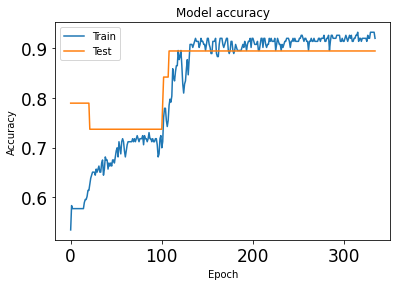

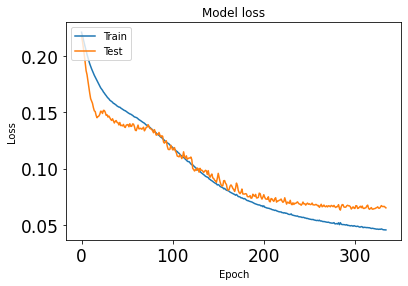

In [178]:
#Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [179]:
y_pred = model.predict(x_test)
y_pred, y_test_label = np.argmax(y_pred,axis=-1),np.argmax(y_test,axis=-1)
acc = accuracy_score(y_pred,y_test_label)
f1 = f1_score(y_pred,y_test_label,average='macro')
print("test_acc = {} | test_f1 = {}".format(acc,f1))

test_acc = 0.9230769230769231 | test_f1 = 0.902225260119997


In [180]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


Multi kernel-size

In [181]:
inputs = Input(shape=(n_steps,n_features))
conv_2 = Conv1D(32,kernel_size=2, activation='relu')(inputs)
o_2 = MaxPooling1D(pool_size=2)(conv_2)

conv_3 = Conv1D(32,kernel_size=3, activation='relu')(inputs)
o_3 = MaxPooling1D(pool_size=3)(conv_3)

merged = concatenate([o_2,o_3], axis=1)
#merged = MaxPooling1D(pool_size=3)(merged)
merged = Flatten()(merged)

out = Dense(24, activation='relu',name='dense')(merged)
out = Dense(3, activation='softmax')(out)

model = keras.Model(inputs, out)
model.compile(optimizer='adam', loss='mse',metrics=['acc'])

In [182]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(x_train, y_train, validation_split=0.1, epochs=500,batch_size=16, verbose=0,callbacks=[early_stopping])

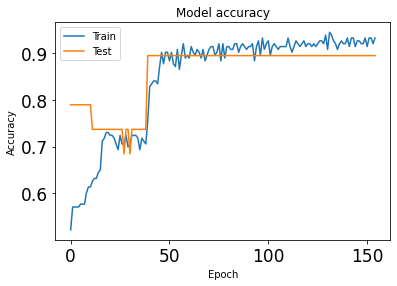

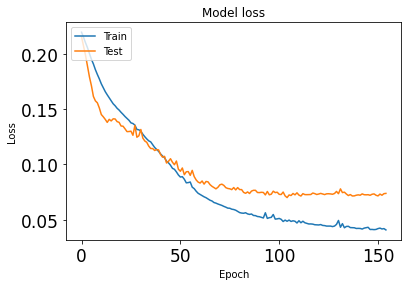

In [183]:
#Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [184]:
y_pred = model.predict(x_test)
y_pred, y_test_label = np.argmax(y_pred,axis=-1),np.argmax(y_test,axis=-1)
acc = accuracy_score(y_pred,y_test_label)
f1 = f1_score(y_pred,y_test_label,average='macro')
print("test_acc = {} | test_f1 = {}".format(acc,f1))

test_acc = 0.8021978021978022 | test_f1 = 0.7823926561790638


### 2) Traditional approach

In [19]:
index_labels = index_labelling(labels,label_map)
x_train, x_test, y_train, y_test = train_test_split(
    samples.reshape(-1,n_steps),index_labels, test_size=0.33, random_state=42)
x_train.shape, y_train.shape

((182, 5), (182, 1))

In [18]:
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, average_precision_score, roc_curve, auc, accuracy_score

In [19]:
def evaluate(clf,X,y,verbose=True):
    y_pred = clf.predict(X)
    acc = accuracy_score(y,y_pred)
    f1 = f1_score(y,y_pred,average='macro')
    print("test_acc = {} | test_f1 = {}".format(acc,f1))

In [20]:
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)
def grid_search(X_train,y_train,model,param_grid,scoring=["f1_macro",'accuracy'],refit="accuracy"):
    print("Grid search to tune hyper-parameters...")
    gs = GridSearchCV(model,param_grid=param_grid,scoring=scoring,refit=refit,cv=kfolds)
    gs.fit(X_train,y_train)
    results = gs.cv_results_
    print("Mean CV ",refit,"=",gs.best_score_," achieved by configuration : ",gs.best_params_)
    best_idx = np.argwhere(results['rank_test_%s' % refit] == 1)[0,0]
    for scorer in scoring:
        for sample in ['test']:
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)][best_idx]
            print("Validation_{} = {}".format(scorer,sample_score_mean))
            #print("validation_",scorer,":",sample_score_mean)
    return gs

### Random Forest

In [ ]:
rf = Pipeline([
        ('rs',RobustScaler()),
        ('rf',RandomForestClassifier(random_state=0))
    ])
param_dist = {"rf__max_depth": [6,7,8,9,10],
              "rf__min_samples_leaf": [3,4,5,6,7],
              "rf__n_estimators": [120,140,160]
             }
gs_rf = grid_search(x_train,y_train,rf,param_dist)

In [21]:
evaluate(gs_rf,x_test,y_test)

test_acc = 0.8901098901098901 | test_f1 = 0.8658883022235443


### SVM

In [233]:
svm = Pipeline([
        ('rs',RobustScaler()),
        ('svm',SVC(kernel='linear',random_state=0,probability=True))
        #('svm',LinearSVC(loss='l2', penalty='l1', dual=False))
    ])
params = {"svm__C":np.logspace(-4, 3, num=30, base=2)}
gs_svm = grid_search(x_train,y_train,svm,params)

Grid search to tune hyper-parameters...
Mean CV  accuracy = 0.6703296703296703  achieved by configuration :  {'svm__C': 5.724863834884453}
Validation_f1_macro = 0.46948250485085596
Validation_accuracy = 0.6703296703296703


In [234]:
evaluate(gs_svm,x_test,y_test)

test_acc = 0.7362637362637363 | test_f1 = 0.5353535353535354


### 3) Hybrid CNN

Using pretrained CNN to extract features

In [21]:
from keras.models import load_model
# load pre-trained CNN model
model = load_model('model.h5')

In [22]:
index_labels = index_labelling(labels,label_map)
x_train, x_test, y_train, y_test = train_test_split(
    samples.reshape(-1,n_steps),index_labels, test_size=0.33, random_state=42)
x_train.shape, y_train.shape

((182, 5), (182, 1))

Extract features using CNN

In [23]:
from keras.models import Model
extract = Model(model.inputs,outputs=model.get_layer('flatten').output)
train_features = extract.predict(x_train.reshape(-1,n_steps,1))
test_features = extract.predict(x_test.reshape(-1,n_steps,1))
train_features.shape,y_train.shape

((182, 64), (182, 1))

Extract weights for visualization

In [24]:
filters = model.get_layer('conv').get_weights()[0]
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [25]:
# # Dimensionality reduction using t-SNE to visualize high-dimensional data
# def plot2D(X,y,algo):
#     cmap = sns.color_palette("husl", 3)
#     df_2d = pd.DataFrame()
#     df_2d['Appliance'] = y
# #     tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=3000)
#     result = algo.fit_transform(X)
#     df_2d['d1'] = result[:,0]
#     df_2d['d2'] = result[:,1]

#     # Make the plot
#     sns.scatterplot(
#         x="d1", y="d2",
#         hue="Appliance",
#         style='Appliance',
#         palette=cmap,
#         data=df_2d,
#         legend="full",
#         alpha=1
#     )

In [26]:
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# plt.figure(figsize=(7, 5))
# #plt.subplot(121)
# tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1500)
# #pca = PCA(n_components=2)
# df_tsne = plot2D(train_features,np.vectorize(lambda i:id2label[int(i)])(y_train[:,0]),tsne)
# plt.savefig('tsne-extract-cnn.png', dpi=300)

In [27]:
# plt.figure(figsize=(7, 5))
# #plt.subplot(121)
# tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1500)
# #pca = PCA(n_components=2)
# df_tsne = plot2D(x_train,np.vectorize(lambda i:id2label[int(i)])(y_train[:,0]),tsne)
# plt.savefig('tsne.png', dpi=300)

### 3.1) CNN features + SVM

In [28]:
svm = Pipeline([
        ('rs',RobustScaler()),
        #('svm',SVC(kernel='linear',random_state=0,probability=True))
        ('svm',OneVsRestClassifier(LinearSVC(loss='l2', penalty='l1', dual=False)))
    ])
params = {"svm__estimator__C":np.logspace(-3, 3, num=50, base=2)}
gs_svm = grid_search(train_features,y_train,svm,params)

Grid search to tune hyper-parameters...
Mean CV  accuracy = 0.9395264116575591  achieved by configuration :  {'svm__estimator__C': 0.6825372037979985}
Validation_f1_macro = 0.9249129172432848
Validation_accuracy = 0.9395264116575591


In [29]:
evaluate(gs_svm,test_features,y_test)

test_acc = 0.8901098901098901 | test_f1 = 0.8602225672877847


In [33]:
pos_imp_feats = [0] * len(id2label)
neg_imp_feats = [0] * len(id2label)

In [34]:
svm_fridge, svm_macbook, svm_washing = gs_svm.best_estimator_['svm'].estimators_

In [35]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

### Visualize filter

### a) Fridge

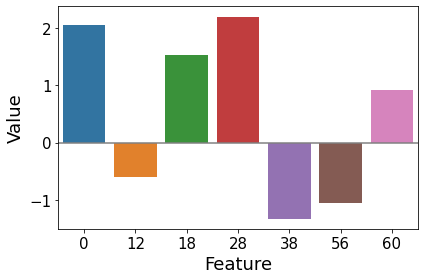

In [38]:
clf = svm_fridge
full_svm_feature_imp = pd.DataFrame(zip(clf.coef_[0],list(range(64))), columns=['Value','Feature'])
# full_svm_feature_imp['imp'] = abs(full_svm_feature_imp['Value'])
full_svm_feature_imp = full_svm_feature_imp[full_svm_feature_imp['Value'] != 0]

pos_imp_feats[label_map['fridge']] = list(full_svm_feature_imp[full_svm_feature_imp['Value'] > 0]['Feature'])
neg_imp_feats[label_map['fridge']] = list(full_svm_feature_imp[full_svm_feature_imp['Value'] < 0]['Feature'])

#fig = plt.figure(figsize=(6, 4))
fig, ax = plt.subplots(figsize=(6, 4))
#full_svm_feature_imp.plot(kind='bar',x='Feature',y='Value')
sns.barplot(x="Feature", y="Value", data=full_svm_feature_imp.sort_values(by="Value", ascending=False),ax=ax)
plt.axhline(y=0, color='gray', linestyle='-',alpha=1)
# plt.title('SVM coefficients')
# plt.yticks()
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel('Feature',fontsize=18)
plt.ylabel('Value',fontsize=18)
change_width(ax, 0.83)
plt.tight_layout()

#plt.title('Dinstictive feature of fridge',fontsize=15)
plt.savefig('svm-feature-importance-fridge-rerun.png',dpi=200)

In [39]:
imp_features = list(full_svm_feature_imp['Feature'])

### Macbook air

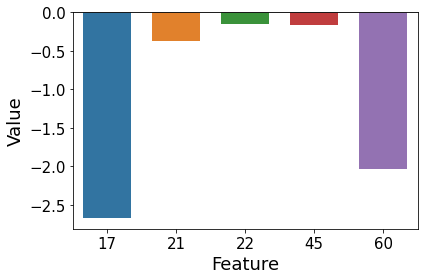

In [39]:
clf = svm_macbook
full_svm_feature_imp = pd.DataFrame(zip(clf.coef_[0],list(range(64))), columns=['Value','Feature'])
# full_svm_feature_imp['imp'] = abs(full_svm_feature_imp['Value'])
full_svm_feature_imp = full_svm_feature_imp[full_svm_feature_imp['Value'] != 0]

pos_imp_feats[label_map['macbook air']] = list(full_svm_feature_imp[full_svm_feature_imp['Value'] > 0]['Feature'])
neg_imp_feats[label_map['macbook air']] = list(full_svm_feature_imp[full_svm_feature_imp['Value'] < 0]['Feature'])

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x="Feature", y="Value",ax=ax, data=full_svm_feature_imp.sort_values(by="Value", ascending=False))
plt.axhline(y=0, color='gray', linestyle='-',alpha=1)
# plt.title('SVM coefficients')
# plt.yticks()
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel('Feature',fontsize=18)
plt.ylabel('Value',fontsize=18)
change_width(ax, 0.7)
plt.tight_layout()
plt.savefig('svm-feature-importance-mac-rerun.png',dpi=200)

In [40]:
imp_features += list(full_svm_feature_imp['Feature'])
# ncol = 2
# nrow = len(imp_features)//ncol
# if len(imp_features) % ncol != 0:
#     nrow += 1
# fig, axes = plt.subplots(nrow,ncol,figsize=(8,4))
# for i,f in enumerate(imp_features):
#     row,col = i//ncol,i%ncol
#     axes[col].set_xticks([])
#     axes[col].set_yticks([])
#     #axes[i].imshow(filters[:, :, f].reshape(1,3), cmap='gray')
#     axes[col].plot(filters[:,:,f].reshape(-1))
#     axes[col].title.set_text('Feature {}'.format(f))
# fig.tight_layout()

# for i in range(len(imp_features),nrow*ncol):
#     row,col = i//ncol,i%ncol
#     axes[col].set_visible(False)
# plt.savefig('filter-mac-rerun.png',dpi=200)

### Washing

<Figure size 432x288 with 0 Axes>

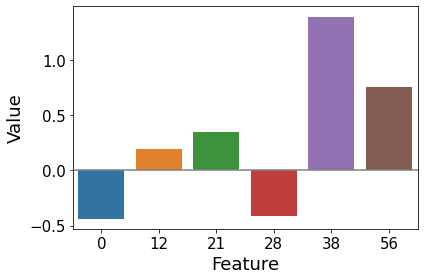

In [45]:
fig = plt.figure(figsize=(6, 4))
clf = svm_washing
full_svm_feature_imp = pd.DataFrame(zip(clf.coef_[0],list(range(64))), columns=['Value','Feature'])
full_svm_feature_imp = full_svm_feature_imp[full_svm_feature_imp['Value'] != 0]

pos_imp_feats[label_map['washing machine']] = list(full_svm_feature_imp[full_svm_feature_imp['Value'] > 0]['Feature'])
neg_imp_feats[label_map['washing machine']] = list(full_svm_feature_imp[full_svm_feature_imp['Value'] < 0]['Feature'])

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x="Feature", y="Value", ax=ax,data=full_svm_feature_imp.sort_values(by="Value", ascending=False))
plt.yticks()
plt.axhline(y=0, color='gray', linestyle='-',alpha=1)
# plt.title('SVM coefficients')
# plt.yticks()
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel('Feature',fontsize=18)
plt.ylabel('Value',fontsize=18)
change_width(ax, 0.8)
plt.tight_layout()

plt.savefig('svm-feature-importance-wm-rerun.png')

In [42]:
imp_features += list(full_svm_feature_imp['Feature'])
print(imp_features)

[0, 12, 18, 28, 38, 56, 60, 17, 21, 22, 45, 60, 0, 12, 21, 28, 38, 56]


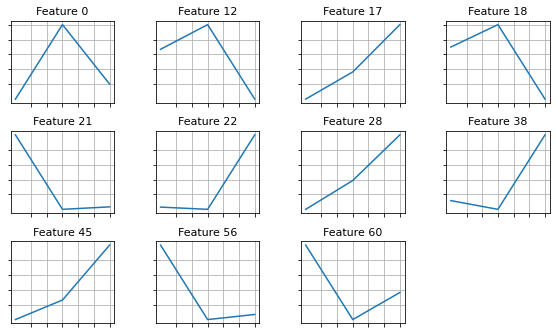

In [43]:
imp_features_ = sorted(set(imp_features))
#imp_features_ = [0,12,17,18,21,22,28,38,45,56,60]
ncol = 4
nrow = len(imp_features_)//ncol
if len(imp_features_) % ncol != 0:
    nrow += 1
fig, axes = plt.subplots(nrow,ncol,figsize=(8,5))
for i,f in enumerate(imp_features_):
    row,col = i//ncol,i%ncol
    y_max,y_min = filters[:,:,f].max(),filters[:,:,f].min()
    step_y = (y_max-y_min)/5
    x_max,x_min = 2,0
    step_x = (x_max-x_min)/6
    axes[row,col].grid()
    axes[row,col].set_xticks(np.arange(x_min+step_x,x_max,step=step_x))
    axes[row,col].set_yticks(np.arange(y_min+step_y,y_max,step=step_y))
    axes[row,col].set_xticklabels([])
    axes[row,col].set_yticklabels([])
    #axes[i].imshow(filters[:, :, f].reshape(1,3), cmap='gray')
    axes[row,col].plot(filters[:,:,f].reshape(-1))
    axes[row,col].title.set_text('Feature {}'.format(f))
    axes[row,col].title.set_size(11)
    
fig.tight_layout()

for i in range(len(imp_features_),nrow*ncol):
    row,col = i//ncol,i%ncol
    axes[row,col].set_visible(False)
plt.savefig('filter.png',dpi=200)

### 3.2) Re-train CNN based on SVM weights

In [624]:
x_train, x_test, y_train, y_test = train_test_split(
    samples,ohe_labels, test_size=0.33, random_state=42)
x_train.shape, y_train.shape

((182, 5, 1), (182, 3))

Re-weigh CNN based on positive/negative SVM importance score

In [625]:
weights = np.zeros((64,3))+1e-5
bias = np.random.normal(size=(3))
# pos_imp_feats = [[13,15,16,44,63],[],[40,48]]
# neg_imp_feats = [[40,48],[13,15,16,63],[]]
for i,imp in enumerate(pos_imp_feats):
    for w in imp:
        weights[w,i] = 1
for i,imp in enumerate(neg_imp_feats):
    for w in imp:
        weights[w,i] = -1

In [626]:
model = load_model('model_improve.h5')
model.get_layer('classifier').set_weights((weights,bias))
model.compile(optimizer='adam', loss='mse',metrics=['acc'])

In [627]:
model.compile(optimizer='adam', loss='mse',metrics=['acc'])

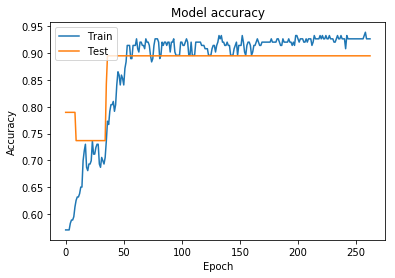

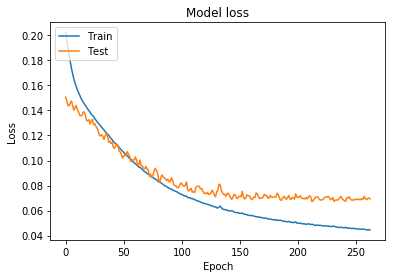

In [628]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(x_train, y_train, validation_split=0.1, epochs=500,batch_size=16, verbose=0,callbacks=[early_stopping])
#Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [630]:
y_pred = model.predict(x_test)
y_pred, y_test_label = np.argmax(y_pred,axis=-1),np.argmax(y_test,axis=-1)
acc = accuracy_score(y_pred,y_test_label)
f1 = f1_score(y_pred,y_test_label,average='macro')
print("test_acc = {} | test_f1 = {}".format(acc,f1))

test_acc = 0.9230769230769231 | test_f1 = 0.902225260119997
